# Homework 

* Create derived statistic for slap and backhand shots
* Note, the analysis can be extended beyond the wrist shot model example
* Assess and report the derived statistics across relevant factors

In [44]:
%matplotlib inline
import os
import sys
import numpy 
import pandas 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# !pip install plotly

# imports regression library
# OLS: ordinary least squares (estimation technique used to estimate the linear regression model)
import statsmodels.api as sm
from statsmodels.formula.api import ols
    
# Set some Pandas options
pandas.set_option('display.notebook_repr_html', True)
pandas.set_option('display.max_columns', 20)
pandas.set_option('display.max_rows', 50)

from decimal import getcontext, Decimal
# Set the precision.
getcontext().prec = 2

In [45]:
dm = pandas.read_csv('shots.csv')
dm = dm[(dm['advantagetypeshooter']=='EV')] 
dm = dm[dm['zone']=="O"]

In [46]:
dm.head(2)

,season,gamenumber,gamedate,vteamcode,hteamcode,eventnumber,period,eventtimefromzero,advantagetypeshooter,advantagetypegoalie,...,position,namegoalie,tgoals,ogoals,zone,X,Y,XNorm,YNorm,shotType
0,2011,20001,10/6/2011,PHI,BOS,4,1,47,EV,EV,...,G,BRYZGALOV_ILYA,0,0,O,32,-14,32,-14,Snap
1,2011,20001,10/6/2011,PHI,BOS,9,1,114,EV,EV,...,G,BRYZGALOV_ILYA,0,0,O,37,-18,37,-18,Snap


In [47]:
dm.describe()

,season,gamenumber,eventnumber,period,eventtimefromzero,isTHome,playernumber,tgoals,ogoals,X,Y,XNorm,YNorm
count,57186.0,57186.000000,57186.000000,57186.000000,57186.00000,57186.000000,57186.000000,57186.000000,57186.000000,57186.000000,57186.000000,57186.000000,57186.000000
mean,2011.0,20621.982094,154.552303,2.034432,584.16901,0.485433,29.926486,1.304480,1.180569,0.264016,-0.178663,62.067604,-0.376613
std,0.0,354.047357,89.652301,0.850648,346.91897,0.499792,13.608431,1.364192,1.280953,64.288069,19.317856,16.750245,19.315011
min,2011.0,20001.000000,3.000000,1.000000,4.00000,0.000000,1.000000,0.000000,0.000000,-99.000000,-42.000000,26.000000,-42.000000
25%,2011.0,20318.000000,77.000000,1.000000,277.00000,0.000000,30.000000,0.000000,0.000000,-64.000000,-15.000000,49.000000,-15.000000
50%,2011.0,20625.000000,154.000000,2.000000,573.00000,0.000000,31.000000,1.000000,1.000000,28.000000,0.000000,64.000000,-1.000000
75%,2011.0,20928.000000,229.000000,3.000000,885.00000,1.000000,35.000000,2.000000,2.000000,64.000000,14.000000,77.000000,14.000000
max,2011.0,21230.000000,392.000000,4.000000,1200.00000,1.000000,70.000000,9.000000,9.000000,97.000000,42.000000,99.000000,42.000000


In [48]:
dm.groupby(['eventtype'])[['XNorm', 'YNorm']].describe()

XNorm         YNorm
eventtype                                  
GOAL      count   4678.000000   4678.000000
          mean      70.962591     -0.132535
          std       13.088705     12.242820
          min       27.000000    -39.000000
          25%       64.000000     -6.000000
          50%       75.000000      0.000000
          75%       81.000000      6.000000
          max       97.000000     40.000000
SHOT      count  52508.000000  52508.000000
          mean      61.275139     -0.398358
          std       16.811628     19.822985
          min       26.000000    -42.000000
          25%       48.000000    -16.000000
          50%       63.000000     -1.000000
          75%       77.000000     15.000000
          max       99.000000     42.000000

In [49]:
pandas.crosstab(dm['shotType'], dm['eventtype'], margins=True)

eventtype,GOAL,SHOT,All
shotType,,,
Backhand,513,4709,5222
Deflected,172,701,873
Slap,545,10716,11261
Snap,681,7574,8255
Tip-In,432,1927,2359
Wrap-around,49,897,946
Wrist,2286,25984,28270
All,4678,52508,57186


In [50]:
dm['isgoal'] = dm['eventtype']=='GOAL'
dm['XNormAdj'] = 99 - dm['XNorm']
dm.groupby(['eventtype'])[['XNormAdj', 'YNorm']].describe()

XNormAdj         YNorm
eventtype                                  
GOAL      count   4678.000000   4678.000000
          mean      28.037409     -0.132535
          std       13.088705     12.242820
          min        2.000000    -39.000000
          25%       18.000000     -6.000000
          50%       24.000000      0.000000
          75%       35.000000      6.000000
          max       72.000000     40.000000
SHOT      count  52508.000000  52508.000000
          mean      37.724861     -0.398358
          std       16.811628     19.822985
          min        0.000000    -42.000000
          25%       22.000000    -16.000000
          50%       36.000000     -1.000000
          75%       51.000000     15.000000
          max       73.000000     42.000000

In [51]:
dm['XNormAdj'] = dm['XNormAdj'] + 1
dm['YNormAdj'] = numpy.absolute(dm['YNorm'])
dm['YNormAdj'] = dm['YNormAdj'] + 1

dm['lnX'] = numpy.log(dm['XNormAdj'])
dm['lnY'] = numpy.log(dm['YNormAdj'])

dm['dscore'] = dm['tgoals'] - dm['ogoals']
dm['oteamcode'] = dm.apply(lambda x: 1 if (x['teamcode'] == x['hteamcode']) else x['vteamcode'], axis=1)

Slapshot specific data

In [52]:
ds = dm[dm['shotType']=='Slap']

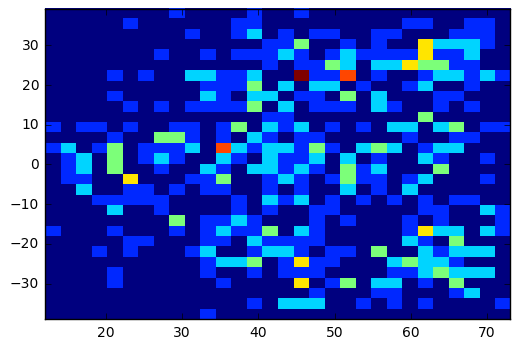

In [53]:
dg = ds[ds['eventtype']=='GOAL']

plt.hist2d(dg['XNormAdj'], dg['YNorm'],bins=30)
plt.show()

Plotting Goals By Length

Optimization terminated successfully.
         Current function value: 0.188123
         Iterations 7
        Logit Marginal Effects       
Dep. Variable:                 isgoal
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
lnX           -0.0633      0.006    -11.380      0.000        -0.074    -0.052


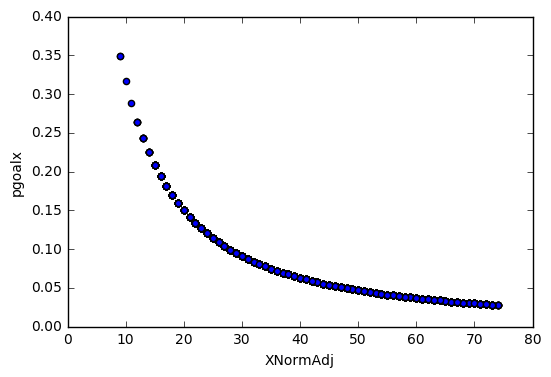

In [54]:
m1 = sm.Logit(ds['isgoal'], sm.add_constant(ds['lnX'])).fit()
print m1.get_margeff(method='dydx', at='overall').summary()

ds.ix[:, 'pgoalx'] = m1.predict()
ds.plot(kind='scatter',x='XNormAdj', y='pgoalx')

Optimization terminated successfully.
         Current function value: 0.189648
         Iterations 7
        Logit Marginal Effects       
Dep. Variable:                 isgoal
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
lnY           -0.0222      0.002     -9.822      0.000        -0.027    -0.018


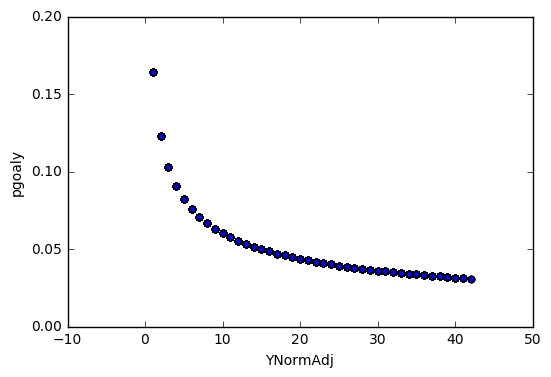

In [55]:
m2 = sm.Logit(ds['isgoal'], sm.add_constant(ds['lnY'])).fit()
print m2.get_margeff(method='dydx', at='overall').summary()

ds.ix[:, 'pgoaly'] = m2.predict()
ds.plot(kind='scatter', x='YNormAdj', y='pgoaly')

In [56]:
m3 = sm.Logit(ds['isgoal'], sm.add_constant(ds[['lnX', 'lnY']])).fit()
print m3.get_margeff(method='dydx', at='overall').summary()
ds.ix[:, 'pgoal'] = m3.predict()

Optimization terminated successfully.
         Current function value: 0.185000
         Iterations 7
        Logit Marginal Effects       
Dep. Variable:                 isgoal
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
lnX           -0.0567      0.005    -10.386      0.000        -0.067    -0.046
lnY           -0.0194      0.002     -8.604      0.000        -0.024    -0.015


In [57]:
ds.describe()

,season,gamenumber,eventnumber,period,eventtimefromzero,isTHome,playernumber,tgoals,ogoals,X,...,XNorm,YNorm,XNormAdj,YNormAdj,lnX,lnY,dscore,pgoalx,pgoaly,pgoal
count,11261.0,11261.000000,11261.000000,11261.000000,11261.000000,11261.000000,11261.000000,11261.000000,11261.000000,11261.000000,...,11261.000000,11261.000000,11261.000000,11261.000000,11261.000000,11261.000000,11261.000000,11261.000000,11261.000000,11261.000000
mean,2011.0,20621.263920,156.163218,2.051061,586.351656,0.485214,30.185596,1.329012,1.191635,0.089512,...,46.154338,0.076370,53.845662,21.936507,3.949742,2.909110,0.137377,0.048397,0.048397,0.048397
std,0.0,354.067573,89.263033,0.855119,347.131590,0.499804,13.776754,1.372788,1.272627,47.875139,...,12.713176,23.104486,12.713176,9.769691,0.291675,0.726367,1.524241,0.026584,0.022026,0.033921
min,2011.0,20001.000000,3.000000,1.000000,4.000000,0.000000,1.000000,0.000000,0.000000,-88.000000,...,26.000000,-41.000000,9.000000,1.000000,2.197225,0.000000,-9.000000,0.027606,0.030813,0.020300
25%,2011.0,20317.000000,80.000000,1.000000,281.000000,0.000000,30.000000,0.000000,0.000000,-43.000000,...,36.000000,-23.000000,46.000000,15.000000,3.828641,2.708050,-1.000000,0.033597,0.036102,0.029572
50%,2011.0,20622.000000,156.000000,2.000000,576.000000,0.000000,31.000000,1.000000,1.000000,27.000000,...,43.000000,0.000000,57.000000,24.000000,4.043051,3.178054,0.000000,0.039260,0.040080,0.037522
75%,2011.0,20926.000000,230.000000,3.000000,886.000000,1.000000,35.000000,2.000000,2.000000,43.000000,...,54.000000,23.000000,64.000000,30.000000,4.158883,3.401197,1.000000,0.052236,0.049875,0.052896
max,2011.0,21230.000000,392.000000,4.000000,1200.000000,1.000000,70.000000,9.000000,9.000000,91.000000,...,91.000000,41.000000,74.000000,42.000000,4.304065,3.737670,9.000000,0.349341,0.164077,0.389619


In [58]:
# season
ds.groupby(['season'])[['isgoal', 'pgoal']].sum()

,isgoal,pgoal
season,,
2011,545.0,545.0


In [59]:
# period
ds.groupby(['period'])[['isgoal', 'pgoal']].sum()

,isgoal,pgoal
period,,
1,158.0,170.148584
2,198.0,183.234769
3,178.0,178.411389
4,11.0,13.205258


In [60]:
# score differential
dw.groupby(['dscore'])[['isgoal', 'pgoal']].sum()

,isgoal,pgoal
dscore,,
-9,0.0,0.040077
-8,0.0,0.092071
-7,1.0,0.123923
-6,1.0,0.448073
-5,1.0,1.749435
-4,10.0,7.355973
-3,17.0,13.792973
-2,53.0,38.408413
-1,99.0,91.762175


In [61]:
# defensive team
dw.groupby(['teamcode'])[['isgoal', 'pgoal']].sum()

,isgoal,pgoal
teamcode,,
ANA,27.0,16.989277
BOS,18.0,16.355484
BUF,21.0,21.230236
CAR,15.0,18.615548
CBJ,22.0,20.259693
CGY,25.0,17.737793
CHI,19.0,21.226418
COL,17.0,17.259665
DAL,23.0,20.282393


In [62]:
# offensive team
dw.groupby(['oteamcode'])[['isgoal', 'pgoal']].sum()

,isgoal,pgoal
oteamcode,,
1,252.0,261.238963
ANA,16.0,8.158821
BOS,13.0,9.890553
BUF,6.0,10.219623
CAR,10.0,10.665697
CBJ,8.0,11.158661
CGY,15.0,9.542436
CHI,12.0,9.597971
COL,9.0,9.523296


Backhand Specific Data

In [63]:
db = dm[dm['shotType']=='Backhand']

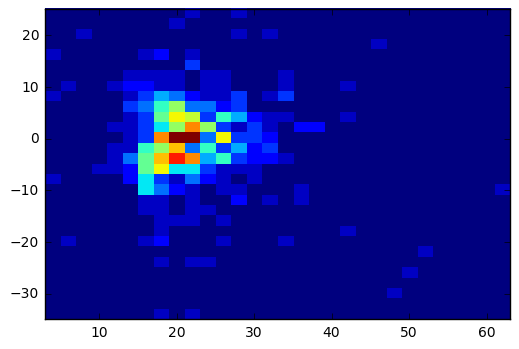

In [65]:
dg = db[db['eventtype']=='GOAL']

plt.hist2d(dg['XNormAdj'], dg['YNorm'],bins=30)
plt.show()

Optimization terminated successfully.
         Current function value: 0.317752
         Iterations 7
        Logit Marginal Effects       
Dep. Variable:                 isgoal
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
lnX           -0.0770      0.013     -5.844      0.000        -0.103    -0.051


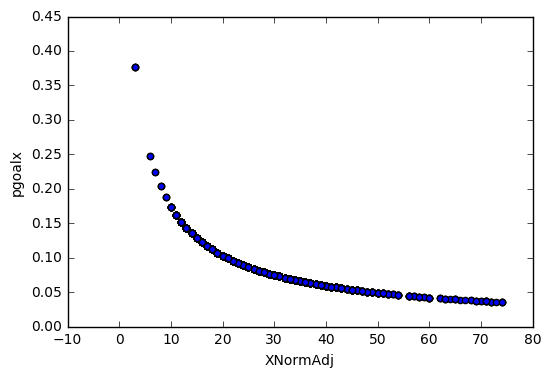

In [66]:
m1 = sm.Logit(db['isgoal'], sm.add_constant(db['lnX'])).fit()
print m1.get_margeff(method='dydx', at='overall').summary()

db.ix[:, 'pgoalx'] = m1.predict()
db.plot(kind='scatter',x='XNormAdj', y='pgoalx')

Optimization terminated successfully.
         Current function value: 0.301774
         Iterations 7
        Logit Marginal Effects       
Dep. Variable:                 isgoal
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
lnY           -0.0652      0.005    -13.630      0.000        -0.075    -0.056


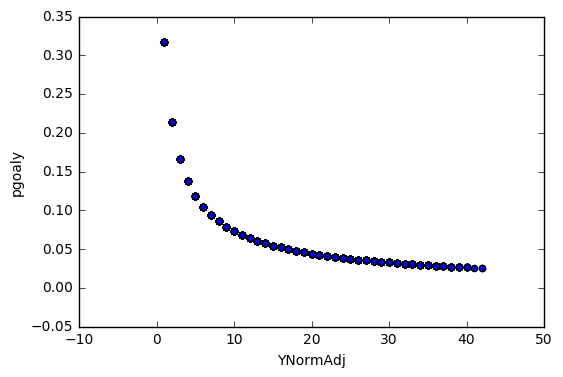

In [67]:
m2 = sm.Logit(db['isgoal'], sm.add_constant(db['lnY'])).fit()
print m2.get_margeff(method='dydx', at='overall').summary()

db.ix[:, 'pgoaly'] = m2.predict()
db.plot(kind='scatter', x='YNormAdj', y='pgoaly')

In [68]:
m3 = sm.Logit(db['isgoal'], sm.add_constant(db[['lnX', 'lnY']])).fit()
print m3.get_margeff(method='dydx', at='overall').summary()
db.ix[:, 'pgoal'] = m3.predict()

Optimization terminated successfully.
         Current function value: 0.297700
         Iterations 7
        Logit Marginal Effects       
Dep. Variable:                 isgoal
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
lnX           -0.0902      0.014     -6.341      0.000        -0.118    -0.062
lnY           -0.0683      0.005    -13.777      0.000        -0.078    -0.059


In [69]:
db.describe()

,season,gamenumber,eventnumber,period,eventtimefromzero,isTHome,playernumber,tgoals,ogoals,X,...,XNorm,YNorm,XNormAdj,YNormAdj,lnX,lnY,dscore,pgoalx,pgoaly,pgoal
count,5222.0,5222.000000,5222.000000,5222.000000,5222.000000,5222.000000,5222.000000,5222.000000,5222.000000,5222.000000,...,5222.000000,5222.000000,5222.000000,5222.000000,5222.000000,5222.000000,5222.000000,5222.000000,5222.000000,5222.000000
mean,2011.0,20622.310417,155.463807,2.038491,587.949828,0.479127,29.869590,1.316162,1.195136,-0.116047,...,76.662581,-2.464764,23.337419,11.243010,3.093281,2.103069,0.121026,0.098238,0.098238,0.098238
std,0.0,350.455459,90.302794,0.852822,347.328575,0.499612,13.707482,1.362129,1.287614,77.157743,...,8.663355,13.260413,8.663355,8.773563,0.328092,0.844278,1.524210,0.024967,0.062573,0.067331
min,2011.0,20001.000000,3.000000,1.000000,5.000000,0.000000,1.000000,0.000000,0.000000,-97.000000,...,26.000000,-41.000000,3.000000,1.000000,1.098612,0.000000,-8.000000,0.035279,0.025408,0.007063
25%,2011.0,20323.000000,77.000000,1.000000,276.250000,0.000000,30.000000,0.000000,0.000000,-79.000000,...,73.000000,-10.000000,18.000000,5.000000,2.890372,1.609438,-1.000000,0.081191,0.054491,0.048466
50%,2011.0,20623.000000,156.000000,2.000000,577.500000,0.000000,31.000000,1.000000,1.000000,-37.500000,...,79.000000,-2.000000,21.000000,9.000000,3.044522,2.197225,0.000000,0.099181,0.078701,0.084774
75%,2011.0,20923.000000,230.000000,3.000000,894.750000,1.000000,35.000000,2.000000,2.000000,79.000000,...,82.000000,5.000000,27.000000,15.000000,3.295837,2.708050,1.000000,0.111901,0.118441,0.128011
max,2011.0,21230.000000,389.000000,4.000000,1200.000000,1.000000,70.000000,9.000000,9.000000,97.000000,...,97.000000,39.000000,74.000000,42.000000,4.304065,3.737670,8.000000,0.376709,0.317063,0.456401


In [70]:
# season
ds.groupby(['season'])[['isgoal', 'pgoal']].sum()

,isgoal,pgoal
season,,
2011,545.0,545.0


In [71]:
# period
ds.groupby(['period'])[['isgoal', 'pgoal']].sum()

,isgoal,pgoal
period,,
1,158.0,170.148584
2,198.0,183.234769
3,178.0,178.411389
4,11.0,13.205258


In [72]:
# score differential
dw.groupby(['dscore'])[['isgoal', 'pgoal']].sum()

,isgoal,pgoal
dscore,,
-9,0.0,0.040077
-8,0.0,0.092071
-7,1.0,0.123923
-6,1.0,0.448073
-5,1.0,1.749435
-4,10.0,7.355973
-3,17.0,13.792973
-2,53.0,38.408413
-1,99.0,91.762175


In [73]:
# defensive team
dw.groupby(['teamcode'])[['isgoal', 'pgoal']].sum()

,isgoal,pgoal
teamcode,,
ANA,27.0,16.989277
BOS,18.0,16.355484
BUF,21.0,21.230236
CAR,15.0,18.615548
CBJ,22.0,20.259693
CGY,25.0,17.737793
CHI,19.0,21.226418
COL,17.0,17.259665
DAL,23.0,20.282393


In [74]:
# offensive team
dw.groupby(['oteamcode'])[['isgoal', 'pgoal']].sum()

,isgoal,pgoal
oteamcode,,
1,252.0,261.238963
ANA,16.0,8.158821
BOS,13.0,9.890553
BUF,6.0,10.219623
CAR,10.0,10.665697
CBJ,8.0,11.158661
CGY,15.0,9.542436
CHI,12.0,9.597971
COL,9.0,9.523296
